# Model Design

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from scripts.data_processor import load_processed_data

classes = {1: 'new', 0: 'used'} # tags for human readabilty
save_graph = True # Option for saving graphs' images

In [2]:
# Logging file
try:
    history = pd.read_csv('./data/train_logs.csv',index_col='training')
    print("Logging file loaded from './data/train_logs.csv'.")
    print(f"Register contains data of {len(history)} trainings.")
except FileNotFoundError:
    print("Logging file was not found. A new logging file was created.")
    history = pd.DataFrame(columns=['features','model','items','cm','metrics','roc_auc'])
    history.index.name = 'training' # Set the name for the DataFrame's index
except Exception as e:
    # Catch other potential errors during CSV loading (e.g., parsing errors)
    print(f"An unexpected error occurred while loading the logging file: {e}")
    print("Creating a new logging file instead.")
    history = pd.DataFrame(columns=['features', 'model', 'items', 'cm', 'metrics', 'roc_auc'])
    history.index.name = 'training'
history

Logging file loaded from './data/train_logs.csv'.
Register contains data of 7 trainings.


,features,model,items,cm,metrics,roc_auc
training,,,,,,
0,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9590577678070668, 0.04094223219293326], [0...","{'new': {'precision': 0.6804615996816554, 'rec...",0.715152
1,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
2,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
3,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
4,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
5,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.5427182650962796, 0.4572817349037203], [0....","{'new': {'precision': 0.9647723496178132, 'rec...",0.759726
6,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.7218171620863713, 0.2781828379136287], [0....","{'new': {'precision': 0.8847387717690193, 'rec...",0.805707


In [ ]:
# Remove last record ('undo' feature)
# history = history.drop(index=len(history)-1)

***NOTE:*** *Each section of this notebook should be run independently, as they correspond to distinct iterations of the productive cycle, alternating between EDA & Feature Selection (`EDA.ipynb`) and Train & Evaluate (`model_design.ipynb`).*

---
---

# 1º iteration - Quick training test

In [ ]:
index = len(history) # used for logging
history.loc[index] = None # Creates an empty row

In [25]:
X_train, y_train, X_test, y_test = load_processed_data()

Importing data from 'new_or_used.py'…
Starting preprocessing…
Succesfully finished.



In [127]:
y_train_lbl = y_train.map(classes)
y_test_lbl = y_test.map(classes)

### Dataset info

In [133]:
size = {'train':len(X_train),'test':len(X_test)}
print("Split sizes: {} train, {} test".format(size['train'], size['test']))

Split sizes: 89109 train, 9905 test


In [134]:
features = {'train': {'feat': None, 'target': None},
            'test': {'feat': None, 'target': None}}

#### Train split

In [137]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89109 entries, 0 to 89108
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   accepts_mercadopago           89109 non-null  uint8  
 1   automatic_relist              89109 non-null  uint8  
 2   price_scaled                  89109 non-null  float64
 3   initial_quantity_scaled       89109 non-null  float64
 4   is_USD                        89109 non-null  uint8  
 5   listing_type_id_free          89109 non-null  float64
 6   listing_type_id_gold          89109 non-null  float64
 7   listing_type_id_gold_premium  89109 non-null  float64
 8   listing_type_id_gold_pro      89109 non-null  float64
 9   listing_type_id_gold_special  89109 non-null  float64
 10  listing_type_id_silver        89109 non-null  float64
 11  buying_mode_buy_it_now        89109 non-null  float64
 12  buying_mode_classified        89109 non-null  float64
 13  s

In [138]:
y_train_lbl.value_counts()

new     47859
used    41250
Name: count, dtype: int64

#### Test split

In [140]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9905 entries, 0 to 9904
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   accepts_mercadopago           9905 non-null   uint8  
 1   automatic_relist              9905 non-null   uint8  
 2   price_scaled                  9905 non-null   float64
 3   initial_quantity_scaled       9905 non-null   float64
 4   is_USD                        9905 non-null   uint8  
 5   listing_type_id_free          9905 non-null   float64
 6   listing_type_id_gold          9905 non-null   float64
 7   listing_type_id_gold_premium  9905 non-null   float64
 8   listing_type_id_gold_pro      9905 non-null   float64
 9   listing_type_id_gold_special  9905 non-null   float64
 10  listing_type_id_silver        9905 non-null   float64
 11  buying_mode_buy_it_now        9905 non-null   float64
 12  buying_mode_classified        9905 non-null   float64
 13  sta

In [141]:
y_test_lbl.value_counts()

new     5349
used    4556
Name: count, dtype: int64

#### Logging

In [142]:
# Keep tracking of every feature
history.at[index, 'items'] = size
features['train']['feat'] = X_train.columns.to_list()
features['test']['feat'] = X_test.columns.to_list()
features['train']['target'] = y_train_lbl.value_counts().to_dict()
features['test']['target'] = y_test_lbl.value_counts().to_dict()
history.at[index, 'features'] = features

## Model training

In [ ]:
# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42)
history.at[index, 'model'] = model.__class__.__name__ # for logging

In [146]:
# Train the model using the scaled training data
print("Training the Logistic Regression model...")
model.fit(X_train, y_train)
print("Model training complete.")

Training the Logistic Regression model...
Model training complete.


## Model evaluation

In [35]:
# Predict on the scaled test data
y_pred = model.predict(X_test)
y_pred_lbl = pd.Series(y_pred).map(classes)

# Getprediction probabilities (useful for ROC curves, etc.
y_pred_proba = model.predict_proba(X_test) 

In [ ]:
# PERFORMANCE EVALUATION
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report (provides Precision, Recall, F1-Score for each class)
class_report = classification_report(y_test_lbl, y_pred_lbl, digits=3)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.7347

Classification Report:
              precision    recall  f1-score   support

         new      0.680     0.959     0.796      5349
        used      0.907     0.471     0.620      4556

    accuracy                          0.735      9905
   macro avg      0.794     0.715     0.708      9905
weighted avg      0.785     0.735     0.715      9905



In [45]:
f1_score(y_test, y_pred, average='binary')

0.7959944108057755

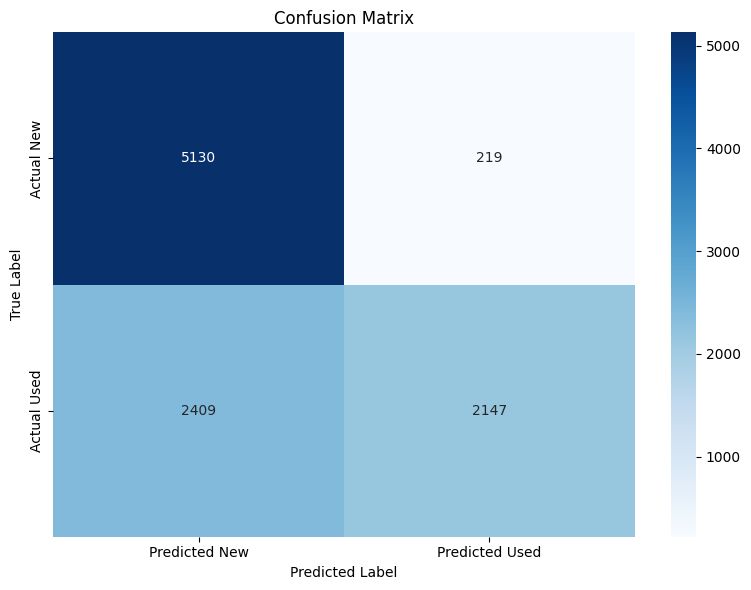

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_lbl, y_pred_lbl)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted New', 'Predicted Used'],
            yticklabels=['Actual New', 'Actual Used'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
if save_graph: plt.savefig('confusion_matrix.png')

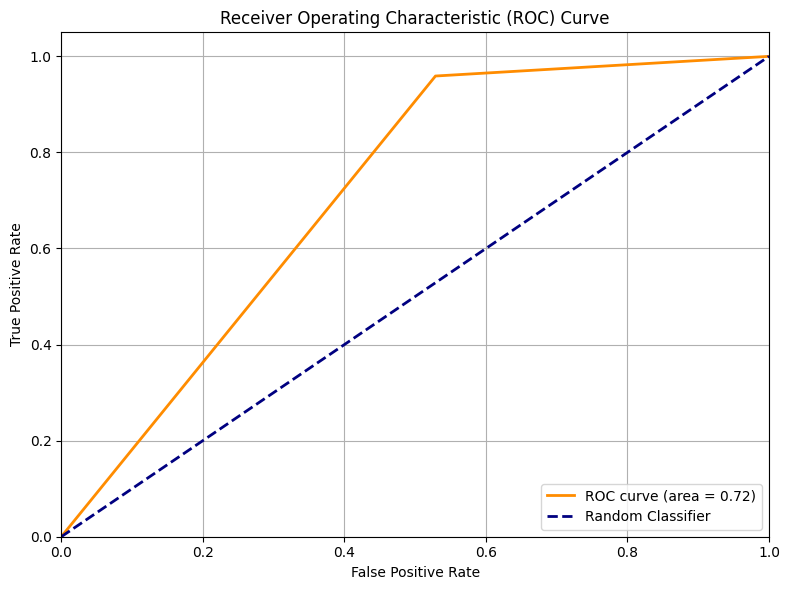

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the probabilities of the positive class (second column)
#y_pred_proba_positive = y_pred_proba[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
if save_graph: plt.savefig('roc_auc_curve.png')

#### Logging

In [ ]:
# Keep tracking of every metric
history.at[index, 'cm'] = confusion_matrix(y_test_lbl, y_pred_lbl,normalize='true').tolist()
history.at[index, 'metrics'] = classification_report(y_test_lbl, y_pred_lbl,output_dict=True)
history.at[index, 'roc_auc'] = auc(fpr, tpr)
history.to_csv('./data/train_logs.csv') # Save logging file locally

In [193]:
history.iloc[index]

features    {'train': {'feat': ['accepts_mercadopago', 'au...
model                                      LogisticRegression
items                          {'train': 89109, 'test': 9905}
cm          [[0.9590577678070668, 0.04094223219293326], [0...
metrics     {'new': {'precision': 0.6804615996816554, 'rec...
roc_auc                                              0.715152
Name: 0, dtype: object

## Analysis

**Key Takeaways:**

1.  **Class Imbalance in Prediction Quality:** The model is **heavily biased towards predicting "new."** It's excellent at identifying "new" items (high recall of 0.96 for 'new'), meaning it correctly catches 96% of all actual "new" items. However, it **struggles significantly with identifying "used" items** (low recall of 0.47 for 'used'), correctly identifying less than half of them. When the model does predict "used," it's usually correct (high precision of 0.91 for 'used'), but it misses a substantial number of actual "used" items. This manifests as a high count of **False Negatives for 'used'** (actual 'used' items misclassified as 'new') and, equivalently, a high count of **False Positives for 'new'** (actual 'used' items misclassified as 'new').

2.  **High False Positives for "new" / High False Negatives for "used":** The **2409 False Positives for "new"** in the confusion matrix explicitly mean that 2409 items that were **actually "used" were incorrectly classified as "new."** This large number directly explains the low recall for "used" ($2147 \text{ TP} / (2147 \text{ TP} + 2409 \text{ FN}) = 0.47$).

3.  **Accuracy is Misleading:** With a significant imbalance in performance across classes and given the class distribution (5349 'new' vs. 4556 'used'), **accuracy alone is not a reliable metric.** The model's strong performance on the slightly larger class ('new') inflates the overall accuracy, masking its poor ability to identify 'used' items.

**Conclusions:**

* Some features are **poor predictors** of the target, showing **correlations close to 0**. This likely contributes to the high number of false positives observed.
* The continuous variables `price` and `quantity` exhibit **highly skewed distributions** with a significant presence of positive outliers. For 'cantidad' in particular, it appears more beneficial to consider if the quantity is simply **greater than 1**, as this seems to influence the probability of an item being 'new'. This suggests a valuable opportunity for feature engineering.
* Regarding the **dummy variables for `listing_type_id`**, only certain categories appear to be relevant. Specifically, the distinction between **paid and free users** seems to be a key differentiator. Notably, 'gold_pro' and 'gold_premium' tiers show little correlation, while lower-tier categories exhibit stronger predictive power.
* The **`status` variable** should not be considered for the model, as the **vast majority of items are 'active'**, providing very little discriminating information.

---
# 2º iteration - Grouping dummies

In [ ]:
index = len(history) # used for logging
history.loc[index] = None # Creates an empty row

In [6]:
X_train, y_train, X_test, y_test = load_processed_data()

Importing data from 'new_or_used.py'…
Starting preprocessing…
Succesfully finished.



In [7]:
X_train.columns

Index(['accepts_mercadopago', 'automatic_relist', 'price_scaled',
       'initial_quantity_scaled', 'is_USD', 'free_tier',
       'buying_mode_buy_it_now', 'buying_mode_classified'],
      dtype='object')

In [8]:
y_train_lbl = y_train.map(classes)
y_test_lbl = y_test.map(classes)

### Dataset info

In [9]:
size = {'train':len(X_train),'test':len(X_test)}
print("Split sizes: {} train, {} test".format(size['train'], size['test']))

Split sizes: 89109 train, 9905 test


In [10]:
features = {'train': {'feat': None, 'target': None},
            'test': {'feat': None, 'target': None}}

#### Train split

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89109 entries, 0 to 89108
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   accepts_mercadopago      89109 non-null  uint8  
 1   automatic_relist         89109 non-null  uint8  
 2   price_scaled             89109 non-null  float64
 3   initial_quantity_scaled  89109 non-null  float64
 4   is_USD                   89109 non-null  uint8  
 5   free_tier                89109 non-null  bool   
 6   buying_mode_buy_it_now   89109 non-null  float64
 7   buying_mode_classified   89109 non-null  float64
dtypes: bool(1), float64(4), uint8(3)
memory usage: 3.1 MB


In [14]:
y_train_lbl.value_counts()

new     47859
used    41250
Name: count, dtype: int64

#### Test split

In [16]:
X_train.drop(columns=['price_scaled'], inplace=True)
X_test.drop(columns=['price_scaled'], inplace=True)

In [17]:
X_train.drop(columns=['is_USD'], inplace=True)
X_test.drop(columns=['is_USD'], inplace=True)

In [18]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9905 entries, 0 to 9904
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   accepts_mercadopago      9905 non-null   uint8  
 1   automatic_relist         9905 non-null   uint8  
 2   initial_quantity_scaled  9905 non-null   float64
 3   free_tier                9905 non-null   bool   
 4   buying_mode_buy_it_now   9905 non-null   float64
 5   buying_mode_classified   9905 non-null   float64
dtypes: bool(1), float64(3), uint8(2)
memory usage: 261.3 KB


In [19]:
y_test_lbl.value_counts()

new     5349
used    4556
Name: count, dtype: int64

#### Logging

In [21]:
# Keep tracking of every feature
history.at[index, 'items'] = size
features['train']['feat'] = X_train.columns.to_list()
features['test']['feat'] = X_test.columns.to_list()
features['train']['target'] = y_train_lbl.value_counts().to_dict()
features['test']['target'] = y_test_lbl.value_counts().to_dict()
history.at[index, 'features'] = features

In [22]:
history

,features,model,items,cm,metrics,roc_auc
training,,,,,,
0,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9590577678070668, 0.04094223219293326], [0...","{'new': {'precision': 0.6804615996816554, 'rec...",0.715152
1,"{'train': {'feat': ['accepts_mercadopago', 'au...",NaN,"{'train': 89109, 'test': 9905}",NaN,NaN,NaN


## Model training

In [23]:
# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42)
history.at[index, 'model'] = model.__class__.__name__ # for logging

In [24]:
# Train the model using the scaled training data
print("Training the Logistic Regression model...")
model.fit(X_train, y_train)
print("Model training complete.")

Training the Logistic Regression model...
Model training complete.


## Model evaluation

In [25]:
# Predict on the scaled test data
y_pred = model.predict(X_test)
y_pred_lbl = pd.Series(y_pred).map(classes)

# Getprediction probabilities (useful for ROC curves, etc.
y_pred_proba = model.predict_proba(X_test) 

In [26]:
# PERFORMANCE EVALUATION
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report (provides Precision, Recall, F1-Score for each class)
class_report = classification_report(y_test_lbl, y_pred_lbl,digits=3)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.7347

Classification Report:
              precision    recall  f1-score   support

         new      0.681     0.958     0.796      5349
        used      0.906     0.472     0.621      4556

    accuracy                          0.735      9905
   macro avg      0.794     0.715     0.708      9905
weighted avg      0.784     0.735     0.715      9905



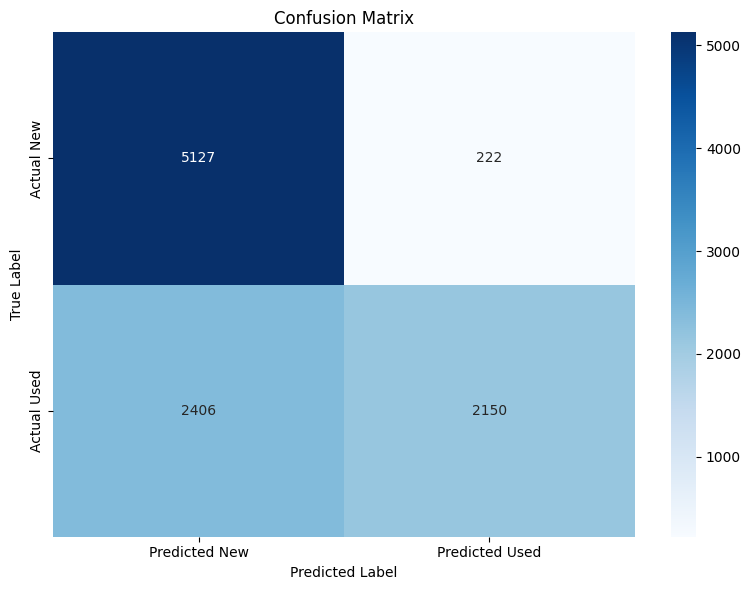

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_lbl, y_pred_lbl)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted New', 'Predicted Used'],
            yticklabels=['Actual New', 'Actual Used'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
if save_graph: plt.savefig('confusion_matrix.png')

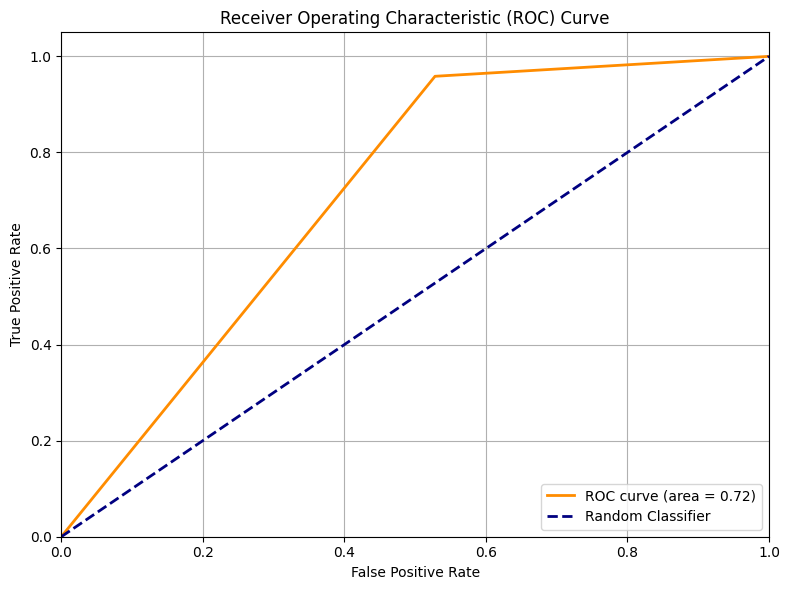

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the probabilities of the positive class (second column)
#y_pred_proba_positive = y_pred_proba[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
if save_graph: plt.savefig('roc_auc_curve.png')

#### Logging

In [29]:
# Keep tracking of every metric
history.at[index, 'cm'] = confusion_matrix(y_test_lbl, y_pred_lbl,normalize='true').tolist()
history.at[index, 'metrics'] = classification_report(y_test_lbl, y_pred_lbl,output_dict=True)
history.at[index, 'roc_auc'] = auc(fpr, tpr)
history.to_csv('./data/train_logs.csv') # Save logging file locally

In [30]:
history.iloc[index]

features    {'train': {'feat': ['accepts_mercadopago', 'au...
model                                      LogisticRegression
items                          {'train': 89109, 'test': 9905}
cm          [[0.9584969153112731, 0.04150308468872686], [0...
metrics     {'new': {'precision': 0.680605336519315, 'reca...
roc_auc                                              0.715201
Name: 1, dtype: object

## Analysis

**Key Takeaways:**

1. The number of **features** was **reduced by 46.7%** without significant impact on performance.

**Conclusions:**

* This represents an improvement in hardware usage, reducing memory needs and processing time.

---
# 3º iteration - Synthetic features

In [ ]:
index = len(history) # used for logging
history.loc[index] = None # Creates an empty row

In [56]:
X_train, y_train, X_test, y_test = load_processed_data()

Importing data from 'new_or_used.py'…
Starting preprocessing…
Succesfully finished.



In [57]:
X_train.columns

Index(['accepts_mercadopago', 'automatic_relist', 'price_scaled',
       'initial_quantity_scaled', 'is_USD', 'free_tier',
       'buying_mode_buy_it_now', 'buying_mode_classified', 'is_weekend',
       'is_working_hours'],
      dtype='object')

In [58]:
y_train_lbl = y_train.map(classes)
y_test_lbl = y_test.map(classes)

### Dataset info

In [59]:
size = {'train':len(X_train),'test':len(X_test)}
print("Split sizes: {} train, {} test".format(size['train'], size['test']))

Split sizes: 89109 train, 9905 test


In [60]:
features = {'train': {'feat': None, 'target': None},
            'test': {'feat': None, 'target': None}}

#### Train split

In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89109 entries, 0 to 89108
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   accepts_mercadopago      89109 non-null  uint8  
 1   automatic_relist         89109 non-null  uint8  
 2   price_scaled             89109 non-null  float64
 3   initial_quantity_scaled  89109 non-null  float64
 4   is_USD                   89109 non-null  uint8  
 5   free_tier                89109 non-null  bool   
 6   buying_mode_buy_it_now   89109 non-null  float64
 7   buying_mode_classified   89109 non-null  float64
 8   is_weekend               89109 non-null  int64  
 9   is_working_hours         89109 non-null  int64  
dtypes: bool(1), float64(4), int64(2), uint8(3)
memory usage: 4.4 MB


In [62]:
y_train_lbl.value_counts()

new     47859
used    41250
Name: count, dtype: int64

#### Test split

In [64]:
X_train.drop(columns=['price_scaled'], inplace=True)
X_test.drop(columns=['price_scaled'], inplace=True)

In [65]:
X_train.drop(columns=['is_USD'], inplace=True)
X_test.drop(columns=['is_USD'], inplace=True)

In [66]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9905 entries, 0 to 9904
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   accepts_mercadopago      9905 non-null   uint8  
 1   automatic_relist         9905 non-null   uint8  
 2   initial_quantity_scaled  9905 non-null   float64
 3   free_tier                9905 non-null   bool   
 4   buying_mode_buy_it_now   9905 non-null   float64
 5   buying_mode_classified   9905 non-null   float64
 6   is_weekend               9905 non-null   int64  
 7   is_working_hours         9905 non-null   int64  
dtypes: bool(1), float64(3), int64(2), uint8(2)
memory usage: 416.1 KB


In [67]:
y_test_lbl.value_counts()

new     5349
used    4556
Name: count, dtype: int64

#### Logging

In [70]:
# Keep tracking of every feature
history.at[index, 'items'] = size
features['train']['feat'] = X_train.columns.to_list()
features['test']['feat'] = X_test.columns.to_list()
features['train']['target'] = y_train_lbl.value_counts().to_dict()
features['test']['target'] = y_test_lbl.value_counts().to_dict()
history.at[index, 'features'] = features

In [71]:
history

,features,model,items,cm,metrics,roc_auc
training,,,,,,
0,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9590577678070668, 0.04094223219293326], [0...","{'new': {'precision': 0.6804615996816554, 'rec...",0.715152
1,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
2,"{'train': {'feat': ['accepts_mercadopago', 'au...",NaN,"{'train': 89109, 'test': 9905}",NaN,NaN,NaN


## Model training

In [ ]:
# Initialize the Logistic Regression model
model = LogisticRegression(class_weight='balanced', random_state=42) # Added balanced classes
history.at[index, 'model'] = model.__class__.__name__ # for logging

In [86]:
# Train the model using the scaled training data
print("Training the Logistic Regression model...")
model.fit(X_train, y_train)
print("Model training complete.")

Training the Logistic Regression model...
Model training complete.


## Model evaluation

In [83]:
# Predict on the scaled test data
y_pred = model.predict(X_test)
y_pred_lbl = pd.Series(y_pred).map(classes)

# Getprediction probabilities (useful for ROC curves, etc.
y_pred_proba = model.predict_proba(X_test) 

In [85]:
# PERFORMANCE EVALUATION
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report (provides Precision, Recall, F1-Score for each class)
class_report = classification_report(y_test_lbl, y_pred_lbl,digits=3)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.7347

Classification Report:
              precision    recall  f1-score   support

         new      0.681     0.958     0.796      5349
        used      0.906     0.472     0.621      4556

    accuracy                          0.735      9905
   macro avg      0.794     0.715     0.708      9905
weighted avg      0.784     0.735     0.715      9905



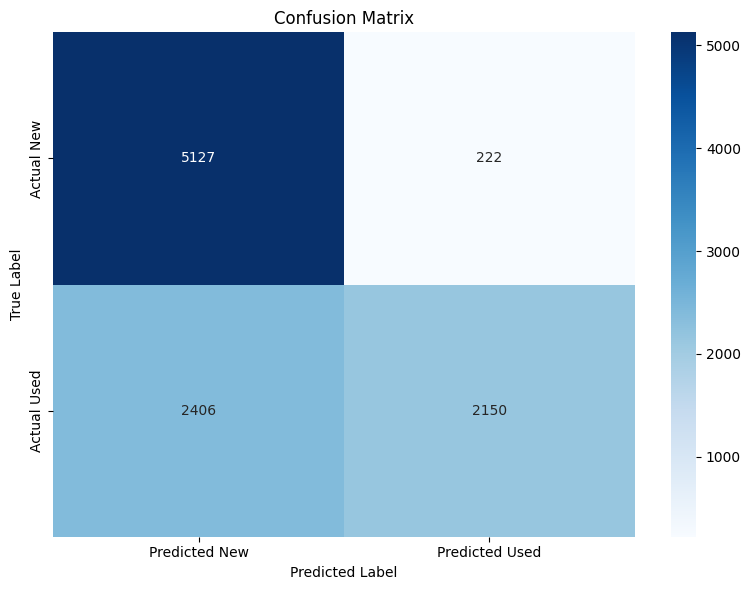

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_lbl, y_pred_lbl)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted New', 'Predicted Used'],
            yticklabels=['Actual New', 'Actual Used'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
if save_graph: plt.savefig('confusion_matrix.png')

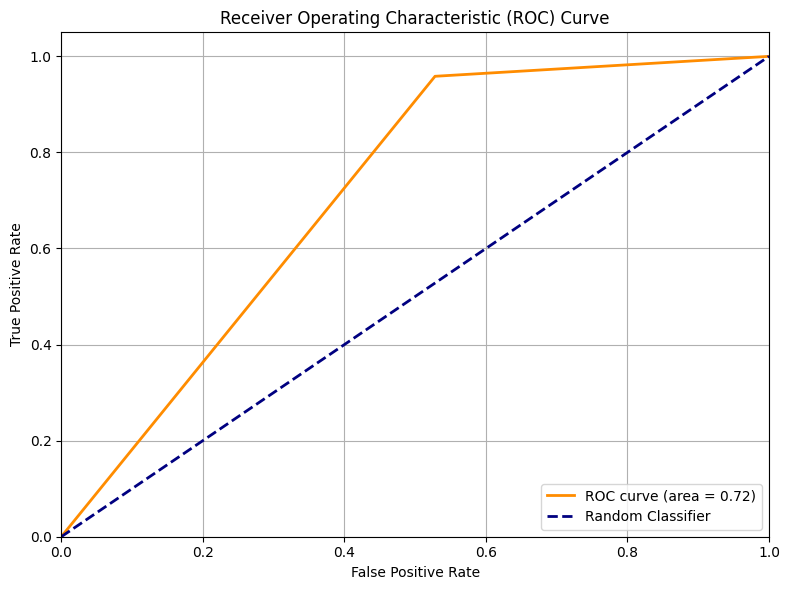

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the probabilities of the positive class (second column)
#y_pred_proba_positive = y_pred_proba[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
if save_graph: plt.savefig('roc_auc_curve.png')

#### Logging

In [79]:
# Keep tracking of every metric
history.at[index, 'cm'] = confusion_matrix(y_test_lbl, y_pred_lbl,normalize='true').tolist()
history.at[index, 'metrics'] = classification_report(y_test_lbl, y_pred_lbl,output_dict=True)
history.at[index, 'roc_auc'] = auc(fpr, tpr)
history.to_csv('./data/train_logs.csv') # Save logging file locally

In [80]:
history.iloc[index]

features    {'train': {'feat': ['accepts_mercadopago', 'au...
model                                      LogisticRegression
items                          {'train': 89109, 'test': 9905}
cm          [[0.9584969153112731, 0.04150308468872686], [0...
metrics     {'new': {'precision': 0.680605336519315, 'reca...
roc_auc                                              0.715201
Name: 2, dtype: object

## Analysis

**Key Takeaways:**

1. There's no any improvement by adding time-related features.
1. Model had exactly the same results as previous training.

**Conclusions:**

* Consistent metric and confusion matrix results across successive classification model trainings often indicate the presence of a few predominant features. 
* This stability implies that the model's decision-making process is heavily reliant on these powerful features, making it less susceptible to minor variations or noise from less influential ones.

### Coefficients Importance

In [ ]:
feature_names = X_train.columns

In [ ]:
# Let's access the coefficients to verify what feature is more influential
coefficients = model.coef_[0]
intercept = model.intercept_[0] 

print("Model Intercept:", intercept)
print("\nCoefficients for each feature:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

print("\n--- Features by Absolute Magnitude (Most Influential) ---")
# Create a DataFrame to sort by absolute coefficient magnitude
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
print(sorted_coef_df)

Model Intercept: -0.6540249894308093

Coefficients for each feature:
accepts_mercadopago: 0.2041
automatic_relist: 2.3862
initial_quantity_scaled: 17.7865
free_tier: -3.1183
buying_mode_buy_it_now: 0.8281
buying_mode_classified: -0.6810
is_weekend: -0.2090
is_working_hours: 0.2146

--- Features by Absolute Magnitude (Most Influential) ---
                   Feature  Coefficient  Abs_Coefficient
2  initial_quantity_scaled    17.786505        17.786505
3                free_tier    -3.118316         3.118316
1         automatic_relist     2.386157         2.386157
4   buying_mode_buy_it_now     0.828097         0.828097
5   buying_mode_classified    -0.681040         0.681040
7         is_working_hours     0.214642         0.214642
6               is_weekend    -0.209016         0.209016
0      accepts_mercadopago     0.204146         0.204146


`initial_quantity_scaled` was by far **the most influential feature** for this model, while **it is actually NOT a strong predictor**, as demonstrated during the predictiveness analysis (0.071924 correlation to target) in the EDA notebook.

Next logical step is to remove it from selected features and check how the model performs.

---
# 4º iteration - Removing 'quantity'

In [ ]:
index = len(history) # used for logging
history.loc[index] = None # Creates an empty row

In [106]:
X_train, y_train, X_test, y_test = load_processed_data()

Importing data from 'new_or_used.py'…


Starting preprocessing…
Succesfully finished.



In [107]:
X_train.columns

Index(['accepts_mercadopago', 'automatic_relist', 'price_scaled', 'is_USD',
       'free_tier', 'buying_mode_buy_it_now', 'buying_mode_classified',
       'is_weekend', 'is_working_hours'],
      dtype='object')

In [108]:
y_train_lbl = y_train.map(classes)
y_test_lbl = y_test.map(classes)

### Dataset info

In [109]:
size = {'train':len(X_train),'test':len(X_test)}
print("Split sizes: {} train, {} test".format(size['train'], size['test']))

Split sizes: 89109 train, 9905 test


In [110]:
features = {'train': {'feat': None, 'target': None},
            'test': {'feat': None, 'target': None}}

#### Train split

In [111]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89109 entries, 0 to 89108
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accepts_mercadopago     89109 non-null  uint8  
 1   automatic_relist        89109 non-null  uint8  
 2   price_scaled            89109 non-null  float64
 3   is_USD                  89109 non-null  uint8  
 4   free_tier               89109 non-null  bool   
 5   buying_mode_buy_it_now  89109 non-null  float64
 6   buying_mode_classified  89109 non-null  float64
 7   is_weekend              89109 non-null  int64  
 8   is_working_hours        89109 non-null  int64  
dtypes: bool(1), float64(3), int64(2), uint8(3)
memory usage: 3.7 MB


In [112]:
y_train_lbl.value_counts()

new     47859
used    41250
Name: count, dtype: int64

#### Test split

In [114]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9905 entries, 0 to 9904
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accepts_mercadopago     9905 non-null   uint8  
 1   automatic_relist        9905 non-null   uint8  
 2   price_scaled            9905 non-null   float64
 3   is_USD                  9905 non-null   uint8  
 4   free_tier               9905 non-null   bool   
 5   buying_mode_buy_it_now  9905 non-null   float64
 6   buying_mode_classified  9905 non-null   float64
 7   is_weekend              9905 non-null   int64  
 8   is_working_hours        9905 non-null   int64  
dtypes: bool(1), float64(3), int64(2), uint8(3)
memory usage: 425.7 KB


In [115]:
y_test_lbl.value_counts()

new     5349
used    4556
Name: count, dtype: int64

#### Logging

In [117]:
# Keep tracking of every feature
history.at[index, 'items'] = size
features['train']['feat'] = X_train.columns.to_list()
features['test']['feat'] = X_test.columns.to_list()
features['train']['target'] = y_train_lbl.value_counts().to_dict()
features['test']['target'] = y_test_lbl.value_counts().to_dict()
history.at[index, 'features'] = features

In [ ]:
history

,features,model,items,cm,metrics,roc_auc
training,,,,,,
0,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9590577678070668, 0.04094223219293326], [0...","{'new': {'precision': 0.6804615996816554, 'rec...",0.715152
1,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
2,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
3,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}",NaN,NaN,NaN


## Model training

In [118]:
# Initialize the Logistic Regression model
model = LogisticRegression(class_weight='balanced', random_state=42)
history.at[index, 'model'] = model.__class__.__name__ # for logging

In [119]:
# Train the model using the scaled training data
print("Training the Logistic Regression model...")
model.fit(X_train, y_train)
print("Model training complete.")

Training the Logistic Regression model...
Model training complete.


## Model evaluation

In [120]:
# Predict on the scaled test data
y_pred = model.predict(X_test)
y_pred_lbl = pd.Series(y_pred).map(classes)

# Getprediction probabilities (useful for ROC curves, etc.
y_pred_proba = model.predict_proba(X_test) 

In [121]:
# PERFORMANCE EVALUATION
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report (provides Precision, Recall, F1-Score for each class)
class_report = classification_report(y_test_lbl, y_pred_lbl,digits=3)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.7347

Classification Report:
              precision    recall  f1-score   support

         new      0.681     0.958     0.796      5349
        used      0.906     0.472     0.621      4556

    accuracy                          0.735      9905
   macro avg      0.794     0.715     0.708      9905
weighted avg      0.784     0.735     0.715      9905



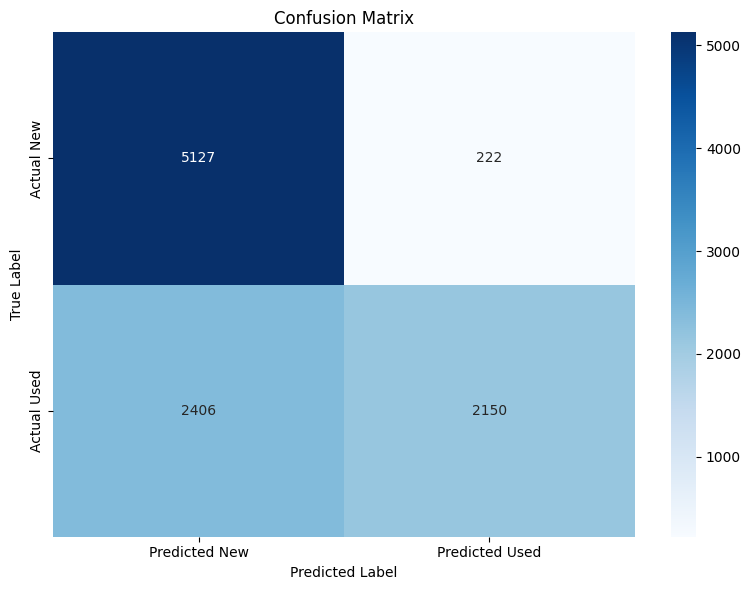

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_lbl, y_pred_lbl)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted New', 'Predicted Used'],
            yticklabels=['Actual New', 'Actual Used'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
if save_graph: plt.savefig('confusion_matrix.png')

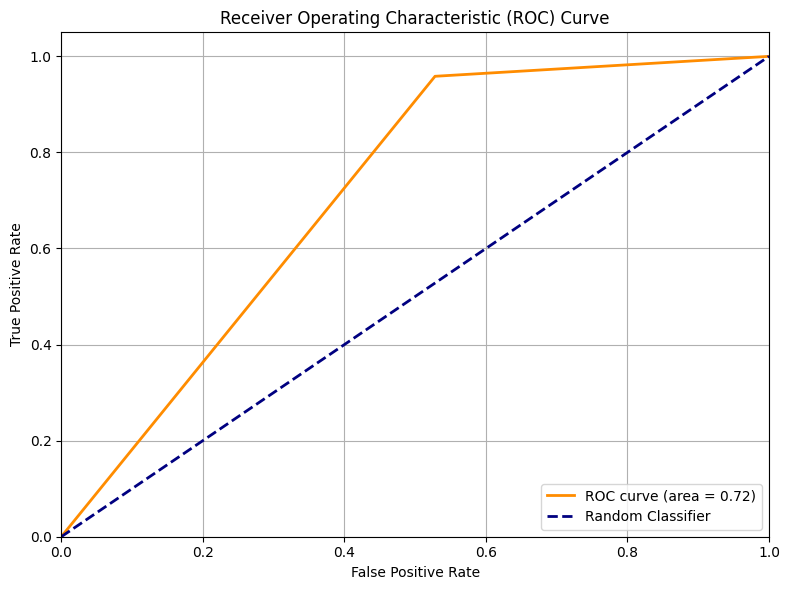

In [123]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the probabilities of the positive class (second column)
#y_pred_proba_positive = y_pred_proba[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
if save_graph: plt.savefig('roc_auc_curve.png')

#### Logging

In [124]:
# Keep tracking of every metric
history.at[index, 'cm'] = confusion_matrix(y_test_lbl, y_pred_lbl,normalize='true').tolist()
history.at[index, 'metrics'] = classification_report(y_test_lbl, y_pred_lbl,output_dict=True)
history.at[index, 'roc_auc'] = auc(fpr, tpr)
history.to_csv('./data/train_logs.csv') # Save logging file locally

In [125]:
history.iloc[index]

features    {'train': {'feat': ['accepts_mercadopago', 'au...
model                                      LogisticRegression
items                          {'train': 89109, 'test': 9905}
cm          [[0.9584969153112731, 0.04150308468872686], [0...
metrics     {'new': {'precision': 0.680605336519315, 'reca...
roc_auc                                              0.715201
Name: 5, dtype: object

### Coefficients Importance

In [130]:
feature_names = X_train.columns

In [131]:
# Let's access the coefficients to verify what feature is more influential
coefficients = model.coef_[0]
intercept = model.intercept_[0] 

print("Model Intercept:", intercept)
print("\nCoefficients for each feature:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

print("\n--- Features by Absolute Magnitude (Most Influential) ---")
# Create a DataFrame to sort by absolute coefficient magnitude
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
print(sorted_coef_df)

Model Intercept: -0.6929335869890125

Coefficients for each feature:
accepts_mercadopago: 0.2103
automatic_relist: 2.4364
price_scaled: 0.0018
is_USD: 0.8070
free_tier: -3.1393
buying_mode_buy_it_now: 0.8888
buying_mode_classified: -0.8917
is_weekend: -0.2085
is_working_hours: 0.2137

--- Features by Absolute Magnitude (Most Influential) ---
                  Feature  Coefficient  Abs_Coefficient
4               free_tier    -3.139337         3.139337
1        automatic_relist     2.436413         2.436413
6  buying_mode_classified    -0.891730         0.891730
5  buying_mode_buy_it_now     0.888835         0.888835
3                  is_USD     0.807041         0.807041
8        is_working_hours     0.213657         0.213657
0     accepts_mercadopago     0.210295         0.210295
7              is_weekend    -0.208487         0.208487
2            price_scaled     0.001750         0.001750


**Features' Predictiveness**
1. free_tier                  0.485303 (#1)
1. automatic_relist           0.187453 (#2)
1. buying_mode_buy_it_now     0.099804 (#4)
1. accepts_mercadopago        0.092842 (#7)
1. buying_mode_classified     0.092842 (#3)
1. initial_quantity_scaled    0.071924
1. price_scaled               0.000968

## Analysis

**Key Takeaways:**

1. Model had similar results as before.
1. Notice how the coefficients of the remaining features have slightly changed. 

**Conclusions:**

* `initial_quantity_scaled` was indeed not contributing meaningfully to the model's actual predictive performance. Its large coefficient in the original model was likely a statistical artifact (e.g., related to multicollinearity), rather than a reflection of true predictive power.
* The model found that `free_tier` and `automatic_relist` are now the most prominent drivers of prediction, which aligns with them being the second and third most influential in your original model.

---
# 5º iteration - Regularization

In [ ]:
index = len(history) # used for logging
history.loc[index] = None # Creates an empty row

In [4]:
X_train, y_train, X_test, y_test = load_processed_data()

Importing data from 'new_or_used.py'…
Starting preprocessing…
Succesfully finished.



In [6]:
y_train_lbl = y_train.map(classes)
y_test_lbl = y_test.map(classes)

### Dataset info

In [7]:
size = {'train':len(X_train),'test':len(X_test)}
print("Split sizes: {} train, {} test".format(size['train'], size['test']))

Split sizes: 89109 train, 9905 test


In [8]:
features = {'train': {'feat': None, 'target': None},
            'test': {'feat': None, 'target': None}}

#### Train split

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89109 entries, 0 to 89108
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accepts_mercadopago     89109 non-null  uint8  
 1   automatic_relist        89109 non-null  uint8  
 2   price_scaled            89109 non-null  float64
 3   is_USD                  89109 non-null  uint8  
 4   free_tier               89109 non-null  bool   
 5   buying_mode_buy_it_now  89109 non-null  float64
 6   buying_mode_classified  89109 non-null  float64
 7   is_weekend              89109 non-null  int64  
 8   is_working_hours        89109 non-null  int64  
dtypes: bool(1), float64(3), int64(2), uint8(3)
memory usage: 3.7 MB


In [10]:
y_train_lbl.value_counts()

new     47859
used    41250
Name: count, dtype: int64

#### Test split

In [11]:
X_train.drop(columns=['price_scaled'], inplace=True)
X_test.drop(columns=['price_scaled'], inplace=True)

In [12]:
X_train.drop(columns=['is_USD'], inplace=True)
X_test.drop(columns=['is_USD'], inplace=True)

In [13]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9905 entries, 0 to 9904
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accepts_mercadopago     9905 non-null   uint8  
 1   automatic_relist        9905 non-null   uint8  
 2   free_tier               9905 non-null   bool   
 3   buying_mode_buy_it_now  9905 non-null   float64
 4   buying_mode_classified  9905 non-null   float64
 5   is_weekend              9905 non-null   int64  
 6   is_working_hours        9905 non-null   int64  
dtypes: bool(1), float64(2), int64(2), uint8(2)
memory usage: 338.7 KB


In [14]:
y_test_lbl.value_counts()

new     5349
used    4556
Name: count, dtype: int64

#### Logging

In [16]:
# Keep tracking of every feature
history.at[index, 'items'] = size
features['train']['feat'] = X_train.columns.to_list()
features['test']['feat'] = X_test.columns.to_list()
features['train']['target'] = y_train_lbl.value_counts().to_dict()
features['test']['target'] = y_test_lbl.value_counts().to_dict()
history.at[index, 'features'] = features

In [ ]:
history

## Model training

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Define a range of C values to test
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create a scorer for the metric you care about most (e.g., F1-score for 'used' class)
# Assuming 'used' is class 1 and 'new' is class 0
# You might need to adjust 'pos_label' based on your class encoding if 'used' is not 1
f1_scorer = make_scorer(f1_score, average='macro', pos_label=1)

grid_search = GridSearchCV(LogisticRegression(penalty='l2', solver='liblinear', random_state=42),
                           param_grid,
                           cv=5, # 5-fold cross-validation
                           scoring=f1_scorer, # Score based on the F1 for 'used'
                           n_jobs=-1) # Use all available cores

grid_search.fit(X_train, y_train)

print(f"Best C value: {grid_search.best_params_['C']}")
print(f"Best F1-score for 'used' with best C: {grid_search.best_score_:.4f}")

# Access the best model
best_model = grid_search.best_estimator_

# Now evaluate this best_model on your test set

Best C value: 0.1
Best F1-score for 'used' with best C: 0.7037


In [19]:
# Initialize the Logistic Regression model
#model = LogisticRegression(class_weight='balanced', random_state=42)
model = LogisticRegression(class_weight='balanced', penalty='l2', C=0.1, solver='liblinear', random_state=42)
history.at[index, 'model'] = model.__class__.__name__ # for logging

In [20]:
# Train the model using the scaled training data
print("Training the Logistic Regression model...")
model.fit(X_train, y_train)
print("Model training complete.")

Training the Logistic Regression model...
Model training complete.


## Model evaluation

In [21]:
# Predict on the scaled test data
y_pred = model.predict(X_test)
y_pred_lbl = pd.Series(y_pred).map(classes)

# Getprediction probabilities (useful for ROC curves, etc.
y_pred_proba = model.predict_proba(X_test) 

In [22]:
# PERFORMANCE EVALUATION
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report (provides Precision, Recall, F1-Score for each class)
class_report = classification_report(y_test_lbl, y_pred_lbl,digits=3)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.7347

Classification Report:
              precision    recall  f1-score   support

         new      0.681     0.958     0.796      5349
        used      0.906     0.472     0.621      4556

    accuracy                          0.735      9905
   macro avg      0.794     0.715     0.708      9905
weighted avg      0.784     0.735     0.715      9905



In [23]:
f1_score(y_test, y_pred,average='weighted')

0.7153503751627156

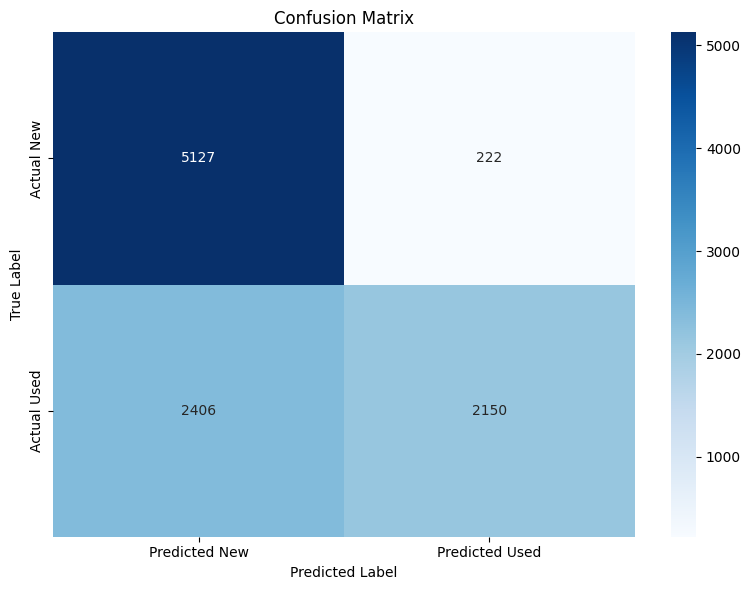

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_lbl, y_pred_lbl)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted New', 'Predicted Used'],
            yticklabels=['Actual New', 'Actual Used'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
if save_graph: plt.savefig('confusion_matrix.png')

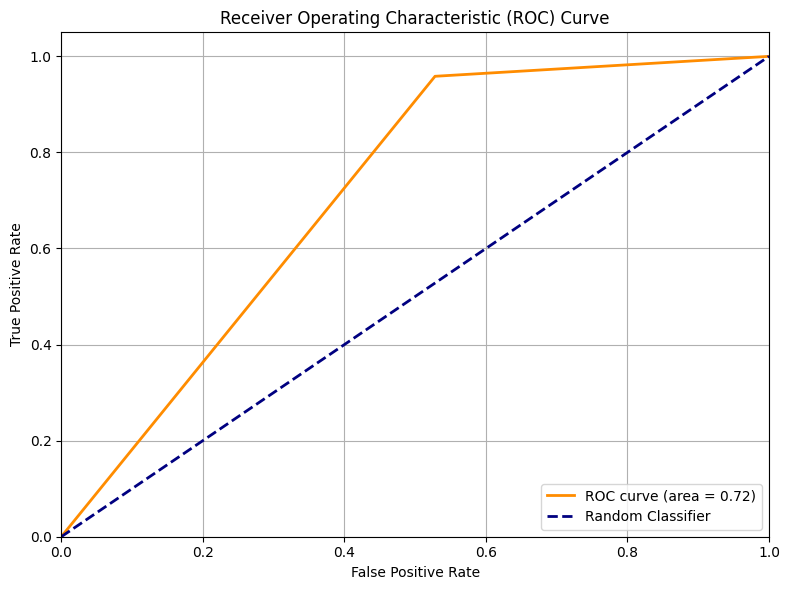

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the probabilities of the positive class (second column)
#y_pred_proba_positive = y_pred_proba[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
if save_graph: plt.savefig('roc_auc_curve.png')

#### Logging

In [31]:
# Keep tracking of every metric
history.at[index, 'cm'] = confusion_matrix(y_test_lbl, y_pred_lbl,normalize='true').tolist()
history.at[index, 'metrics'] = classification_report(y_test_lbl, y_pred_lbl,output_dict=True)
history.at[index, 'roc_auc'] = auc(fpr, tpr)
history.to_csv('./data/train_logs.csv') # Save logging file locally

In [27]:
history.iloc[index]

features    {'train': {'feat': ['accepts_mercadopago', 'au...
model                                      LogisticRegression
items                          {'train': 89109, 'test': 9905}
cm          [[0.9584969153112731, 0.04150308468872686], [0...
metrics     {'new': {'precision': 0.680605336519315, 'reca...
roc_auc                                              0.715201
Name: 6, dtype: object

### Coefficients Importance

In [28]:
feature_names = X_train.columns

In [30]:
# Let's access the coefficients to verify what feature is more influential
coefficients = model.coef_[0]
intercept = model.intercept_[0] 

print("Model Intercept:", intercept)
print("\nCoefficients for each feature:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

print("\n--- Features by Absolute Magnitude (Most Influential) ---")
# Create a DataFrame to sort by absolute coefficient magnitude
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
print(sorted_coef_df)

Model Intercept: -0.5684123844419986

Coefficients for each feature:
accepts_mercadopago: 0.1754
automatic_relist: 2.3319
free_tier: -3.1167
buying_mode_buy_it_now: 0.8000
buying_mode_classified: -0.7438
is_weekend: -0.2084
is_working_hours: 0.2109

--- Features by Absolute Magnitude (Most Influential) ---
                  Feature  Coefficient  Abs_Coefficient
2               free_tier    -3.116681         3.116681
1        automatic_relist     2.331881         2.331881
3  buying_mode_buy_it_now     0.800023         0.800023
4  buying_mode_classified    -0.743798         0.743798
6        is_working_hours     0.210899         0.210899
5              is_weekend    -0.208427         0.208427
0     accepts_mercadopago     0.175385         0.175385


1. free_tier                  0.485303 (#1)
1. automatic_relist           0.187453 (#2)
1. buying_mode_buy_it_now     0.099804 (#3)
1. accepts_mercadopago        0.092842
1. buying_mode_classified     0.092842 (#4)
1. initial_quantity_scaled    0.071924
1. status_paused              0.067348
1. is_USD                     0.025116
1. status_not_yet_active      0.003110
1. price_scaled               0.000968

## Analysis

1. Model had similar results as before.
1. Notice how the coefficients of the remaining features have slightly changed.

**Conclusions:**

* Even when it's not impacting in model performance, we can see that applying L2 reg is penalizing even more `accepts_mercadopago`. However, this was detected to be more correlated with target that other features.

---
# 6º iteration - Categorical quantity

In [ ]:
index = len(history) # used for logging
history.loc[index] = None # Creates an empty row

In [45]:
X_train, y_train, X_test, y_test = load_processed_data()

Importing data from 'new_or_used.py'…
Starting preprocessing…
Succesfully finished.



In [46]:
X_train.columns

Index(['accepts_mercadopago', 'automatic_relist', 'price_scaled', 'is_USD',
       'free_tier', 'buying_mode_buy_it_now', 'buying_mode_classified',
       'is_weekend', 'is_working_hours', 'quant_single_unit', 'quant_small'],
      dtype='object')

In [47]:
y_train_lbl = y_train.map(classes)
y_test_lbl = y_test.map(classes)

### Dataset info

In [48]:
size = {'train':len(X_train),'test':len(X_test)}
print("Split sizes: {} train, {} test".format(size['train'], size['test']))

Split sizes: 89109 train, 9905 test


In [49]:
features = {'train': {'feat': None, 'target': None},
            'test': {'feat': None, 'target': None}}

#### Train split

In [50]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89109 entries, 0 to 89108
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accepts_mercadopago     89109 non-null  uint8  
 1   automatic_relist        89109 non-null  uint8  
 2   price_scaled            89109 non-null  float64
 3   is_USD                  89109 non-null  uint8  
 4   free_tier               89109 non-null  bool   
 5   buying_mode_buy_it_now  89109 non-null  float64
 6   buying_mode_classified  89109 non-null  float64
 7   is_weekend              89109 non-null  int64  
 8   is_working_hours        89109 non-null  int64  
 9   quant_single_unit       89109 non-null  bool   
 10  quant_small             89109 non-null  bool   
dtypes: bool(3), float64(3), int64(2), uint8(3)
memory usage: 3.9 MB


In [51]:
y_train_lbl.value_counts()

new     47859
used    41250
Name: count, dtype: int64

#### Test split

In [53]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9905 entries, 0 to 9904
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accepts_mercadopago     9905 non-null   uint8  
 1   automatic_relist        9905 non-null   uint8  
 2   price_scaled            9905 non-null   float64
 3   is_USD                  9905 non-null   uint8  
 4   free_tier               9905 non-null   bool   
 5   buying_mode_buy_it_now  9905 non-null   float64
 6   buying_mode_classified  9905 non-null   float64
 7   is_weekend              9905 non-null   int64  
 8   is_working_hours        9905 non-null   int64  
 9   quant_single_unit       9905 non-null   bool   
 10  quant_small             9905 non-null   bool   
dtypes: bool(3), float64(3), int64(2), uint8(3)
memory usage: 445.1 KB


In [54]:
y_test_lbl.value_counts()

new     5349
used    4556
Name: count, dtype: int64

#### Logging

In [ ]:
# Keep tracking of every feature
history.at[index, 'items'] = size
features['train']['feat'] = X_train.columns.to_list()
features['test']['feat'] = X_test.columns.to_list()
features['train']['target'] = y_train_lbl.value_counts().to_dict()
features['test']['target'] = y_test_lbl.value_counts().to_dict()
history.at[index, 'features'] = features

In [ ]:
history

,features,model,items,cm,metrics,roc_auc
training,,,,,,
0,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9590577678070668, 0.04094223219293326], [0...","{'new': {'precision': 0.6804615996816554, 'rec...",0.715152
1,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
2,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
3,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}",NaN,NaN,NaN


## Model training

In [61]:
# Initialize the Logistic Regression model
#model = LogisticRegression(class_weight='balanced', random_state=42)
model = LogisticRegression(class_weight='balanced', penalty='l2', C=0.1, solver='liblinear', random_state=42)
history.at[index, 'model'] = model.__class__.__name__ # for logging

In [62]:
# Train the model using the scaled training data
print("Training the Logistic Regression model...")
model.fit(X_train, y_train)
print("Model training complete.")

Training the Logistic Regression model...
Model training complete.


## Model evaluation

In [63]:
# Predict on the scaled test data
y_pred = model.predict(X_test)
y_pred_lbl = pd.Series(y_pred).map(classes)

# Getprediction probabilities (useful for ROC curves, etc.
y_pred_proba = model.predict_proba(X_test) 

In [64]:
# PERFORMANCE EVALUATION
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report (provides Precision, Recall, F1-Score for each class)
class_report = classification_report(y_test_lbl, y_pred_lbl,digits=3)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.7424

Classification Report:
              precision    recall  f1-score   support

         new      0.965     0.543     0.695      5349
        used      0.645     0.977     0.777      4556

    accuracy                          0.742      9905
   macro avg      0.805     0.760     0.736      9905
weighted avg      0.818     0.742     0.733      9905



In [65]:
f1_score(y_test, y_pred,average='binary')

0.6946637951663077

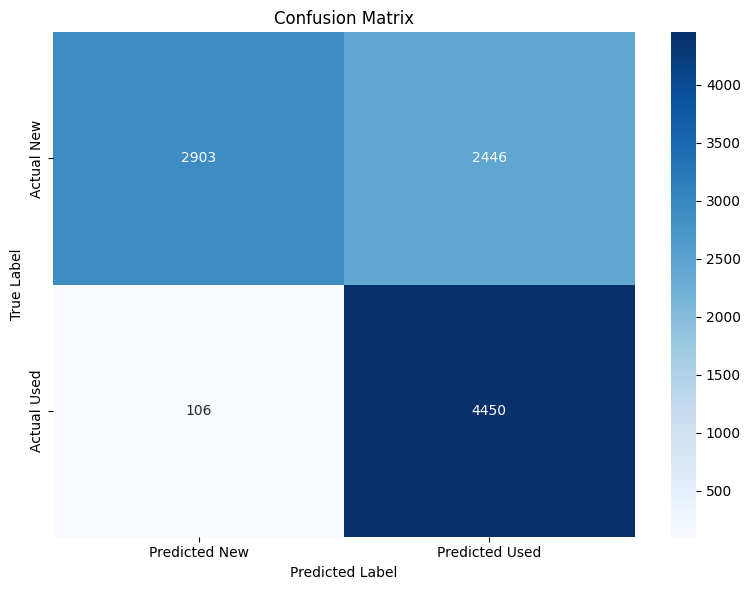

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_lbl, y_pred_lbl)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted New', 'Predicted Used'],
            yticklabels=['Actual New', 'Actual Used'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
if save_graph: plt.savefig('confusion_matrix.png')

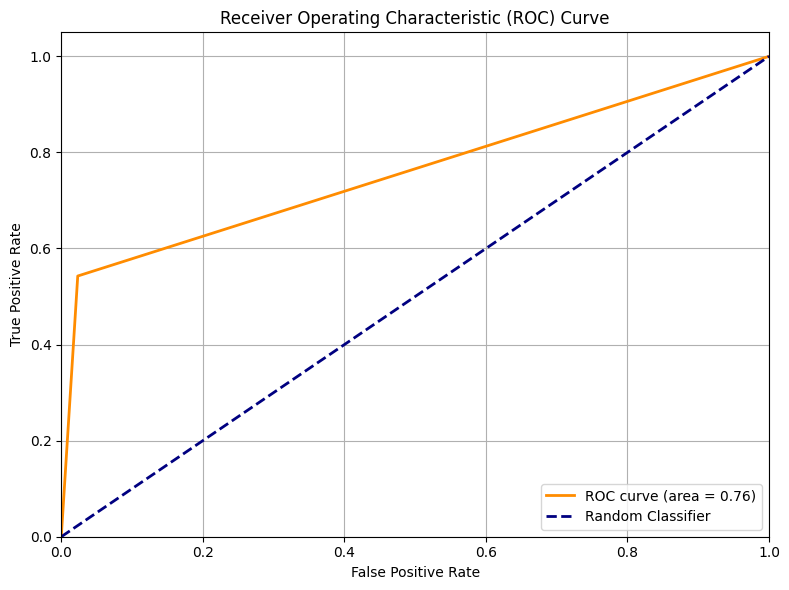

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the probabilities of the positive class (second column)
#y_pred_proba_positive = y_pred_proba[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
if save_graph: plt.savefig('roc_auc_curve.png')

#### Logging

In [ ]:
# Keep tracking of every metric
history.at[index, 'cm'] = confusion_matrix(y_test_lbl, y_pred_lbl,normalize='true').tolist()
history.at[index, 'metrics'] = classification_report(y_test_lbl, y_pred_lbl,output_dict=True)
history.at[index, 'roc_auc'] = auc(fpr, tpr)
history.to_csv('./data/train_logs.csv') # Save logging file locally

In [ ]:
history.iloc[index]

features    {'train': {'feat': ['accepts_mercadopago', 'au...
model                                      LogisticRegression
items                          {'train': 89109, 'test': 9905}
cm          [[0.5427182650962796, 0.4572817349037203], [0....
metrics     {'new': {'precision': 0.9647723496178132, 'rec...
roc_auc                                              0.759726
Name: 6, dtype: object

### Coefficients Importance

In [ ]:
feature_names = X_train.columns

In [ ]:
# Let's access the coefficients to verify what feature is more influential
coefficients = model.coef_[0]
intercept = model.intercept_[0] 

print("Model Intercept:", intercept)
print("\nCoefficients for each feature:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

print("\n--- Features by Absolute Magnitude (Most Influential) ---")
# Create a DataFrame to sort by absolute coefficient magnitude
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
print(sorted_coef_df)

Model Intercept: 1.864626552270474

Coefficients for each feature:
accepts_mercadopago: 1.3194
automatic_relist: 1.5625
free_tier: -2.7130
buying_mode_buy_it_now: 0.2526
buying_mode_classified: 0.5088
is_weekend: -0.1405
is_working_hours: 0.1727
quant_single_unit: -3.6907
quant_small: -0.9940

--- Features by Absolute Magnitude (Most Influential) ---
                  Feature  Coefficient  Abs_Coefficient
7       quant_single_unit    -3.690727         3.690727
2               free_tier    -2.713048         2.713048
1        automatic_relist     1.562547         1.562547
0     accepts_mercadopago     1.319410         1.319410
8             quant_small    -0.994010         0.994010
4  buying_mode_classified     0.508783         0.508783
3  buying_mode_buy_it_now     0.252574         0.252574
6        is_working_hours     0.172680         0.172680
5              is_weekend    -0.140487         0.140487


1. free_tier                  0.485303 (#1)
1. automatic_relist           0.187453 (#2)
1. buying_mode_buy_it_now     0.099804 (#3)
1. accepts_mercadopago        0.092842
1. buying_mode_classified     0.092842 (#4)
1. initial_quantity_scaled    0.071924
1. status_paused              0.067348
1. is_USD                     0.025116
1. status_not_yet_active      0.003110
1. price_scaled               0.000968

## Analysis

1. Model had similar results as before.
1. Notice how the coefficients of the remaining features have slightly changed.
1. Now we moved to the other end, instead of FN we have FP.

**Conclusions:**

* Even when it's not impacting in model performance, we can see that applying L2 reg is penalizing even more `accepts_mercadopago`. However, this was detected to be more correlated with target that other features.

---
# 7º iteration - Synthetic features

In [3]:
index = len(history) # used for logging
history.loc[index] = None # Creates an empty row

In [4]:
X_train, y_train, X_test, y_test = load_processed_data()

Importing data from 'new_or_used.py'…
Starting preprocessing…
Succesfully finished.



In [5]:
X_train.columns

Index(['accepts_mercadopago', 'automatic_relist', 'price_scaled', 'is_USD',
       'free_tier', 'buying_mode_buy_it_now', 'buying_mode_classified',
       'is_weekend', 'is_working_hours', 'has_parent_item', 'has_store',
       'high_ticket', 'quant_single_unit', 'quant_small'],
      dtype='object')

In [6]:
y_train_lbl = y_train.map(classes)
y_test_lbl = y_test.map(classes)

### Dataset info

In [7]:
size = {'train':len(X_train),'test':len(X_test)}
print("Split sizes: {} train, {} test".format(size['train'], size['test']))

Split sizes: 89109 train, 9905 test


In [8]:
features = {'train': {'feat': None, 'target': None},
            'test': {'feat': None, 'target': None}}

#### Train split

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89109 entries, 0 to 89108
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accepts_mercadopago     89109 non-null  uint8  
 1   automatic_relist        89109 non-null  uint8  
 2   price_scaled            89109 non-null  float64
 3   is_USD                  89109 non-null  uint8  
 4   free_tier               89109 non-null  bool   
 5   buying_mode_buy_it_now  89109 non-null  float64
 6   buying_mode_classified  89109 non-null  float64
 7   is_weekend              89109 non-null  int64  
 8   is_working_hours        89109 non-null  int64  
 9   has_parent_item         89109 non-null  bool   
 10  has_store               89109 non-null  bool   
 11  high_ticket             89109 non-null  bool   
 12  quant_single_unit       89109 non-null  bool   
 13  quant_small             89109 non-null  bool   
dtypes: bool(6), float64(3), int64(2), uint

In [10]:
y_train_lbl.value_counts()

new     47859
used    41250
Name: count, dtype: int64

#### Test split

In [11]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9905 entries, 0 to 9904
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accepts_mercadopago     9905 non-null   uint8  
 1   automatic_relist        9905 non-null   uint8  
 2   price_scaled            9905 non-null   float64
 3   is_USD                  9905 non-null   uint8  
 4   free_tier               9905 non-null   bool   
 5   buying_mode_buy_it_now  9905 non-null   float64
 6   buying_mode_classified  9905 non-null   float64
 7   is_weekend              9905 non-null   int64  
 8   is_working_hours        9905 non-null   int64  
 9   has_parent_item         9905 non-null   bool   
 10  has_store               9905 non-null   bool   
 11  high_ticket             9905 non-null   bool   
 12  quant_single_unit       9905 non-null   bool   
 13  quant_small             9905 non-null   bool   
dtypes: bool(6), float64(3), int64(2), uint8(

In [12]:
y_test_lbl.value_counts()

new     5349
used    4556
Name: count, dtype: int64

#### Logging

In [13]:
# Keep tracking of every feature
history.at[index, 'items'] = size
features['train']['feat'] = X_train.columns.to_list()
features['test']['feat'] = X_test.columns.to_list()
features['train']['target'] = y_train_lbl.value_counts().to_dict()
features['test']['target'] = y_test_lbl.value_counts().to_dict()
history.at[index, 'features'] = features

In [14]:
history

,features,model,items,cm,metrics,roc_auc
training,,,,,,
0,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9590577678070668, 0.04094223219293326], [0...","{'new': {'precision': 0.6804615996816554, 'rec...",0.715152
1,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
2,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
3,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
4,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
5,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.5427182650962796, 0.4572817349037203], [0....","{'new': {'precision': 0.9647723496178132, 'rec...",0.759726
6,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.5427182650962796, 0.4572817349037203], [0....","{'new': {'precision': 0.9647723496178132, 'rec...",0.759726
7,"{'train': {'feat': ['accepts_mercadopago', 'au...",NaN,"{'train': 89109, 'test': 9905}",NaN,NaN,NaN


## Model training

In [15]:
# Initialize the Logistic Regression model
#model = LogisticRegression(class_weight='balanced', random_state=42)
model = LogisticRegression(class_weight='balanced', penalty='l2', C=0.1, solver='liblinear', random_state=42)
history.at[index, 'model'] = model.__class__.__name__ # for logging

In [16]:
# Train the model using the scaled training data
print("Training the Logistic Regression model...")
model.fit(X_train, y_train)
print("Model training complete.")

Training the Logistic Regression model...


Model training complete.


## Model evaluation

In [17]:
# Predict on the scaled test data
y_pred = model.predict(X_test)
y_pred_lbl = pd.Series(y_pred).map(classes)

# Getprediction probabilities (useful for ROC curves, etc.
y_pred_proba = model.predict_proba(X_test) 

In [18]:
# PERFORMANCE EVALUATION
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report (provides Precision, Recall, F1-Score for each class)
class_report = classification_report(y_test_lbl, y_pred_lbl,digits=3)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.7990

Classification Report:
              precision    recall  f1-score   support

         new      0.885     0.722     0.795      5349
        used      0.731     0.890     0.803      4556

    accuracy                          0.799      9905
   macro avg      0.808     0.806     0.799      9905
weighted avg      0.814     0.799     0.799      9905



In [20]:
f1_score(y_test, y_pred,average='binary')

0.7950169875424689

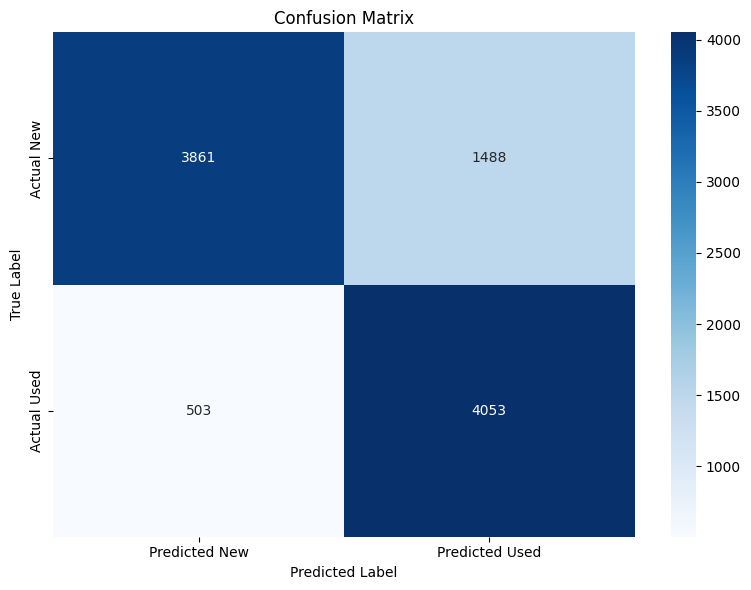

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_lbl, y_pred_lbl)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted New', 'Predicted Used'],
            yticklabels=['Actual New', 'Actual Used'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
if save_graph: plt.savefig('confusion_matrix.png')

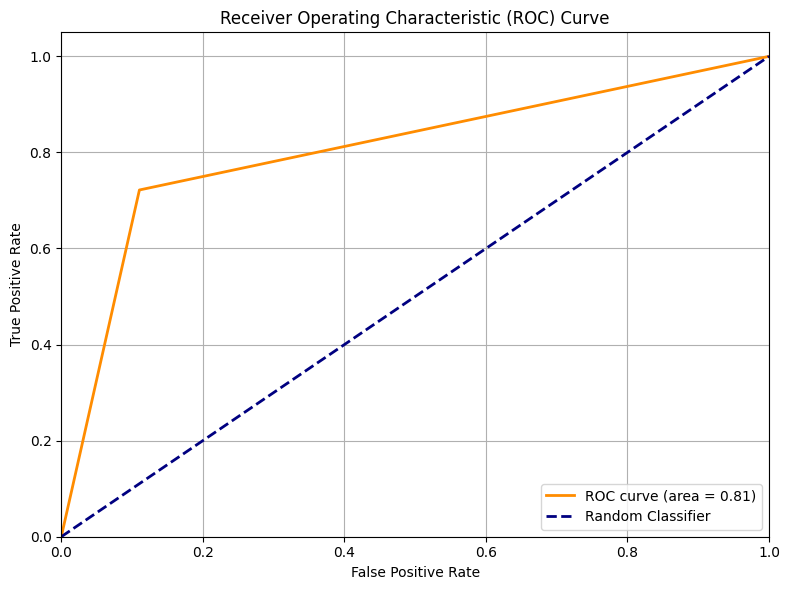

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the probabilities of the positive class (second column)
#y_pred_proba_positive = y_pred_proba[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
if save_graph: plt.savefig('roc_auc_curve.png')

#### Logging

In [23]:
# Keep tracking of every metric
history.at[index, 'cm'] = confusion_matrix(y_test_lbl, y_pred_lbl,normalize='true').tolist()
history.at[index, 'metrics'] = classification_report(y_test_lbl, y_pred_lbl,output_dict=True)
history.at[index, 'roc_auc'] = auc(fpr, tpr)
history.to_csv('./data/train_logs.csv') # Save logging file locally

In [24]:
history.iloc[index]

features    {'train': {'feat': ['accepts_mercadopago', 'au...
model                                      LogisticRegression
items                          {'train': 89109, 'test': 9905}
cm          [[0.7218171620863713, 0.2781828379136287], [0....
metrics     {'new': {'precision': 0.8847387717690193, 'rec...
roc_auc                                              0.805707
Name: 7, dtype: object

### Coefficients Importance

In [25]:
feature_names = X_train.columns

In [26]:
# Let's access the coefficients to verify what feature is more influential
coefficients = model.coef_[0]
intercept = model.intercept_[0] 

print("Model Intercept:", intercept)
print("\nCoefficients for each feature:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

print("\n--- Features by Absolute Magnitude (Most Influential) ---")
# Create a DataFrame to sort by absolute coefficient magnitude
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
print(sorted_coef_df)

Model Intercept: 1.5785301610053846

Coefficients for each feature:
accepts_mercadopago: 1.9132
automatic_relist: 1.3988
price_scaled: -0.0103
is_USD: 0.6663
free_tier: -3.1383
buying_mode_buy_it_now: 0.2128
buying_mode_classified: -0.3346
is_weekend: -0.1175
is_working_hours: 0.1724
has_parent_item: -0.7608
has_store: 0.0393
high_ticket: 1.0599
quant_single_unit: -3.5038
quant_small: -0.7997

--- Features by Absolute Magnitude (Most Influential) ---
                   Feature  Coefficient  Abs_Coefficient
12       quant_single_unit    -3.503841         3.503841
4                free_tier    -3.138295         3.138295
0      accepts_mercadopago     1.913174         1.913174
1         automatic_relist     1.398815         1.398815
11             high_ticket     1.059936         1.059936
13             quant_small    -0.799689         0.799689
9          has_parent_item    -0.760776         0.760776
3                   is_USD     0.666286         0.666286
6   buying_mode_classified    -0

1. free_tier                  0.485303 (#1)
1. automatic_relist           0.187453 (#2)
1. buying_mode_buy_it_now     0.099804 (#3)
1. accepts_mercadopago        0.092842
1. buying_mode_classified     0.092842 (#4)
1. initial_quantity_scaled    0.071924
1. status_paused              0.067348
1. is_USD                     0.025116
1. status_not_yet_active      0.003110
1. price_scaled               0.000968

## Analysis

1. Model performance has improved significantly.
1. Now `accepts_mercadopago` gets relevant as expected.
1. `price_scaled`remains without much contribution.

**Conclusions:**
* Now that price data is contained as categorical, `price_scaled` could be removed.

---
# 8º iteration - Random Forest

In [3]:
index = len(history) # used for logging
history.loc[index] = None # Creates an empty row

In [4]:
X_train, y_train, X_test, y_test = load_processed_data()

Importing data from 'new_or_used.py'…
Starting preprocessing…
Succesfully finished.



In [5]:
X_train.columns

Index(['accepts_mercadopago', 'automatic_relist', 'price_scaled', 'is_USD',
       'free_tier', 'buying_mode_buy_it_now', 'buying_mode_classified',
       'is_weekend', 'is_working_hours', 'has_parent_item', 'has_store',
       'high_ticket', 'quant_single_unit', 'quant_small'],
      dtype='object')

In [6]:
y_train_lbl = y_train.map(classes)
y_test_lbl = y_test.map(classes)

### Dataset info

In [7]:
size = {'train':len(X_train),'test':len(X_test)}
print("Split sizes: {} train, {} test".format(size['train'], size['test']))

Split sizes: 89109 train, 9905 test


In [8]:
features = {'train': {'feat': None, 'target': None},
            'test': {'feat': None, 'target': None}}

#### Train split

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89109 entries, 0 to 89108
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accepts_mercadopago     89109 non-null  uint8  
 1   automatic_relist        89109 non-null  uint8  
 2   price_scaled            89109 non-null  float64
 3   is_USD                  89109 non-null  uint8  
 4   free_tier               89109 non-null  bool   
 5   buying_mode_buy_it_now  89109 non-null  float64
 6   buying_mode_classified  89109 non-null  float64
 7   is_weekend              89109 non-null  int64  
 8   is_working_hours        89109 non-null  int64  
 9   has_parent_item         89109 non-null  bool   
 10  has_store               89109 non-null  bool   
 11  high_ticket             89109 non-null  bool   
 12  quant_single_unit       89109 non-null  bool   
 13  quant_small             89109 non-null  bool   
dtypes: bool(6), float64(3), int64(2), uint

In [10]:
y_train_lbl.value_counts()

new     47859
used    41250
Name: count, dtype: int64

#### Test split

In [11]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9905 entries, 0 to 9904
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accepts_mercadopago     9905 non-null   uint8  
 1   automatic_relist        9905 non-null   uint8  
 2   price_scaled            9905 non-null   float64
 3   is_USD                  9905 non-null   uint8  
 4   free_tier               9905 non-null   bool   
 5   buying_mode_buy_it_now  9905 non-null   float64
 6   buying_mode_classified  9905 non-null   float64
 7   is_weekend              9905 non-null   int64  
 8   is_working_hours        9905 non-null   int64  
 9   has_parent_item         9905 non-null   bool   
 10  has_store               9905 non-null   bool   
 11  high_ticket             9905 non-null   bool   
 12  quant_single_unit       9905 non-null   bool   
 13  quant_small             9905 non-null   bool   
dtypes: bool(6), float64(3), int64(2), uint8(

In [12]:
y_test_lbl.value_counts()

new     5349
used    4556
Name: count, dtype: int64

#### Logging

In [13]:
# Keep tracking of every feature
history.at[index, 'items'] = size
features['train']['feat'] = X_train.columns.to_list()
features['test']['feat'] = X_test.columns.to_list()
features['train']['target'] = y_train_lbl.value_counts().to_dict()
features['test']['target'] = y_test_lbl.value_counts().to_dict()
history.at[index, 'features'] = features

In [14]:
history

,features,model,items,cm,metrics,roc_auc
training,,,,,,
0,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9590577678070668, 0.04094223219293326], [0...","{'new': {'precision': 0.6804615996816554, 'rec...",0.715152
1,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
2,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
3,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
4,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.9584969153112731, 0.04150308468872686], [0...","{'new': {'precision': 0.680605336519315, 'reca...",0.715201
5,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.5427182650962796, 0.4572817349037203], [0....","{'new': {'precision': 0.9647723496178132, 'rec...",0.759726
6,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}","[[0.7218171620863713, 0.2781828379136287], [0....","{'new': {'precision': 0.8847387717690193, 'rec...",0.805707
7,"{'train': {'feat': ['accepts_mercadopago', 'au...",NaN,"{'train': 89109, 'test': 9905}",NaN,NaN,NaN


## Model training

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Logistic Regression model
#model = LogisticRegression(class_weight='balanced', random_state=42)
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
history.at[index, 'model'] = model.__class__.__name__ # for logging

In [16]:
# Train the model using the scaled training data
print("Training the Logistic Regression model...")
model.fit(X_train, y_train)
print("Model training complete.")

Training the Logistic Regression model...
Model training complete.


## Model evaluation

In [17]:
# Predict on the scaled test data
y_pred = model.predict(X_test)
y_pred_lbl = pd.Series(y_pred).map(classes)

# Getprediction probabilities (useful for ROC curves, etc.
y_pred_proba = model.predict_proba(X_test) 

In [18]:
# PERFORMANCE EVALUATION
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report (provides Precision, Recall, F1-Score for each class)
class_report = classification_report(y_test_lbl, y_pred_lbl,digits=3)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.8219

Classification Report:
              precision    recall  f1-score   support

         new      0.880     0.777     0.825      5349
        used      0.769     0.875     0.819      4556

    accuracy                          0.822      9905
   macro avg      0.824     0.826     0.822      9905
weighted avg      0.829     0.822     0.822      9905



In [19]:
f1_score(y_test, y_pred,average='binary')

0.8248610007942812

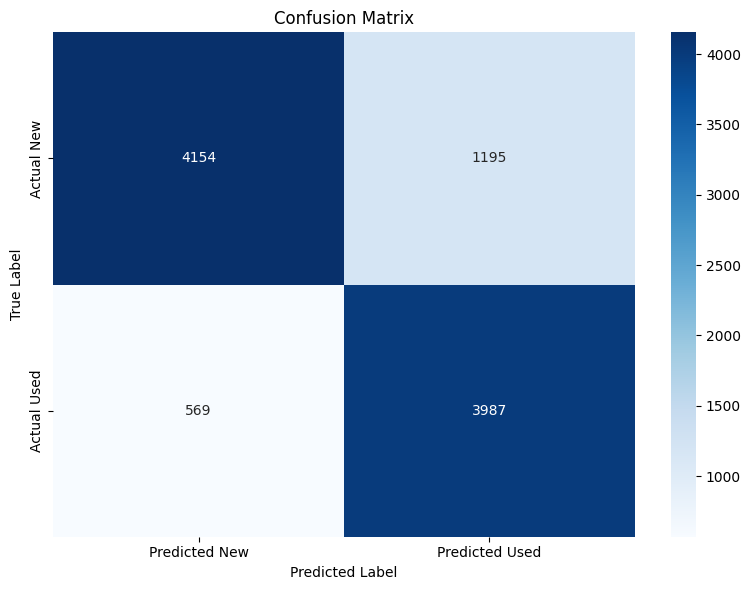

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_lbl, y_pred_lbl)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted New', 'Predicted Used'],
            yticklabels=['Actual New', 'Actual Used'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
if save_graph: plt.savefig('confusion_matrix.png')

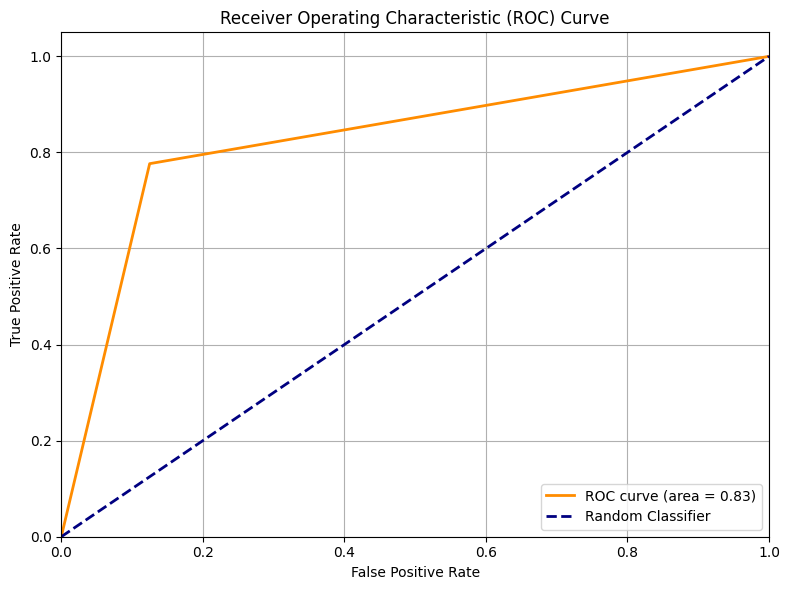

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the probabilities of the positive class (second column)
#y_pred_proba_positive = y_pred_proba[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
if save_graph: plt.savefig('roc_auc_curve.png')

#### Logging

In [22]:
# Keep tracking of every metric
history.at[index, 'cm'] = confusion_matrix(y_test_lbl, y_pred_lbl,normalize='true').tolist()
history.at[index, 'metrics'] = classification_report(y_test_lbl, y_pred_lbl,output_dict=True)
history.at[index, 'roc_auc'] = auc(fpr, tpr)
history.to_csv('./data/train_logs.csv') # Save logging file locally

In [23]:
history.iloc[index]

features    {'train': {'feat': ['accepts_mercadopago', 'au...
model                                  RandomForestClassifier
items                          {'train': 89109, 'test': 9905}
cm          [[0.7765937558422135, 0.2234062441577865], [0....
metrics     {'new': {'precision': 0.8795257251746771, 'rec...
roc_auc                                              0.825852
Name: 7, dtype: object

## Analysis

1. Model performance has improved significantly over all metrics.
1. Better balance between precision and recall for both classes (reduced FP & FN).

**Conclusions:**
* The **Random Forest model is generally superior** for this classification task.